In [1]:
import numpy as np

def theoretical_psd(noise_type, frequencies, total_power):
    """Compute the theoretical PSD for a given noise type and total integrated power.

    Parameters
    ----------
    noise_type : str
        One of ['white', 'pink', 'brownian', 'blue', 'violet'].
    frequencies : ndarray
        Frequency array (Hz).
    total_power : float
        Desired total power (area under the PSD curve in units of (amplitude)^2).

    Returns
    -------
    psd : ndarray
        Theoretical PSD with the specified total power.
    """

    # Define unnormalized spectral shapes
    spectra = {
        'white': lambda f: np.ones_like(f),
        'blue': lambda f: f,
        'violet': lambda f: f**2,
        'pink': lambda f: 1.0 / np.where(f == 0, np.inf, f),
        'brownian': lambda f: 1.0 / np.where(f == 0, np.inf, f**2)
    }

    if noise_type not in spectra:
        raise ValueError(f"Unsupported noise type: {noise_type}")

    S = spectra[noise_type](frequencies)

    # Prevent infinities or NaNs from contaminating integration
    S[np.isnan(S)] = 0.0
    S[np.isinf(S)] = 0.0

    # Numerically integrate raw spectrum to normalize
    df = np.gradient(frequencies)
    raw_area = np.sum(S * df)

    if raw_area == 0:
        raise RuntimeError("Raw area under PSD is zero — likely due to bad frequency input.")

    # Normalize to match desired total power
    psd = (total_power / raw_area) * S
    return psd


Saved: noise_psd_from_white.npy
Saved: noise_psd_from_blue.npy
Saved: noise_psd_from_violet.npy
Saved: noise_psd_from_pink.npy
Saved: noise_psd_from_brownian.npy


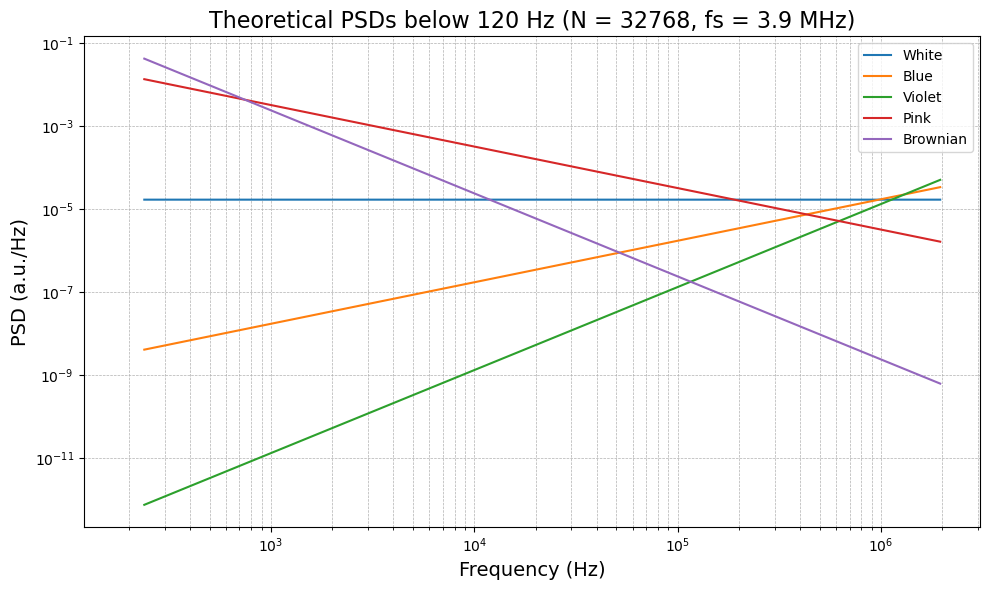

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfftfreq

# Sampling parameters
fs = 3_906_250  # Hz
N = 32768       # length of signal
frequencies = rfftfreq(N, d=1.0 / fs)
total_power = 33.2

# Define spectral shapes
spectra = {
    'white': lambda f: np.ones_like(f),
    'blue': lambda f: f,
    'violet': lambda f: f**2,
    'pink': lambda f: 1.0 / np.where(f == 0, np.inf, f),
    'brownian': lambda f: 1.0 / np.where(f == 0, np.inf, f**2)
}

def theoretical_psd(noise_type, frequencies, total_power):
    S = spectra[noise_type](frequencies)
    S[np.isnan(S)] = 0.0
    S[np.isinf(S)] = 0.0
    df = np.gradient(frequencies)
    raw_area = np.sum(S * df)
    if raw_area == 0:
        raise RuntimeError(f"Raw area under PSD is zero for {noise_type}.")
    psd = (total_power / raw_area) * S
    return psd

# Compute and save PSDs
psds = {}

for noise_type in spectra:
    psd = theoretical_psd(noise_type, frequencies, total_power)
    psds[noise_type] = psd
    np.save(f"noise_psd_from_{noise_type}.npy", psd)
    print(f"Saved: noise_psd_from_{noise_type}.npy")

# Plot only frequencies up to 120 Hz
plt.figure(figsize=(10, 6))
for noise_type, psd in psds.items():
    mask = frequencies >= 120  # Keep only frequencies <= 120 Hz
    plt.loglog(frequencies[mask], psd[mask], label=noise_type.capitalize())
plt.xlim(left=120)  # Start x-axis at 120 Hz
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('PSD (a.u./Hz)', fontsize=14)
plt.title('Theoretical PSDs below 120 Hz (N = 32768, fs = 3.9 MHz)', fontsize=16)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [16]:
mmc_noise=np.load("../templates/noise_psd_from_MMC.npy")